In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA AND PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [ ]:
path = '/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/phmap_train'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_3rd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_2nd_Unbalance.csv', 'train_2nd_Looseness.csv', 'train_2nd_Bearing.csv']


In [ ]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128  # 왜 -128로 빼는 걸까?
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

### DATA Loading

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

In [ ]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]

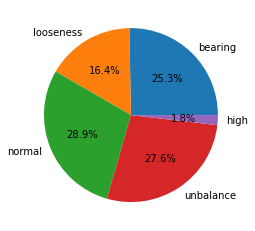

In [ ]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [ ]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487004/487004 [00:27<00:00, 17499.21it/s]


In [ ]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:10<00:00, 18093.73it/s]


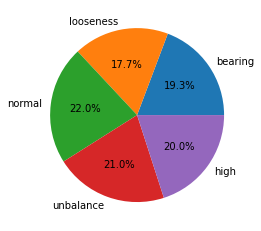

In [ ]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(128).prefetch(1)

In [ ]:
Valid_Dataset = Dataset.take(3000) 
Train_Dataset = Dataset.skip(3000)

In [ ]:
Test_Dataset = test_Dataset.batch(128)

# VISUALIZATION

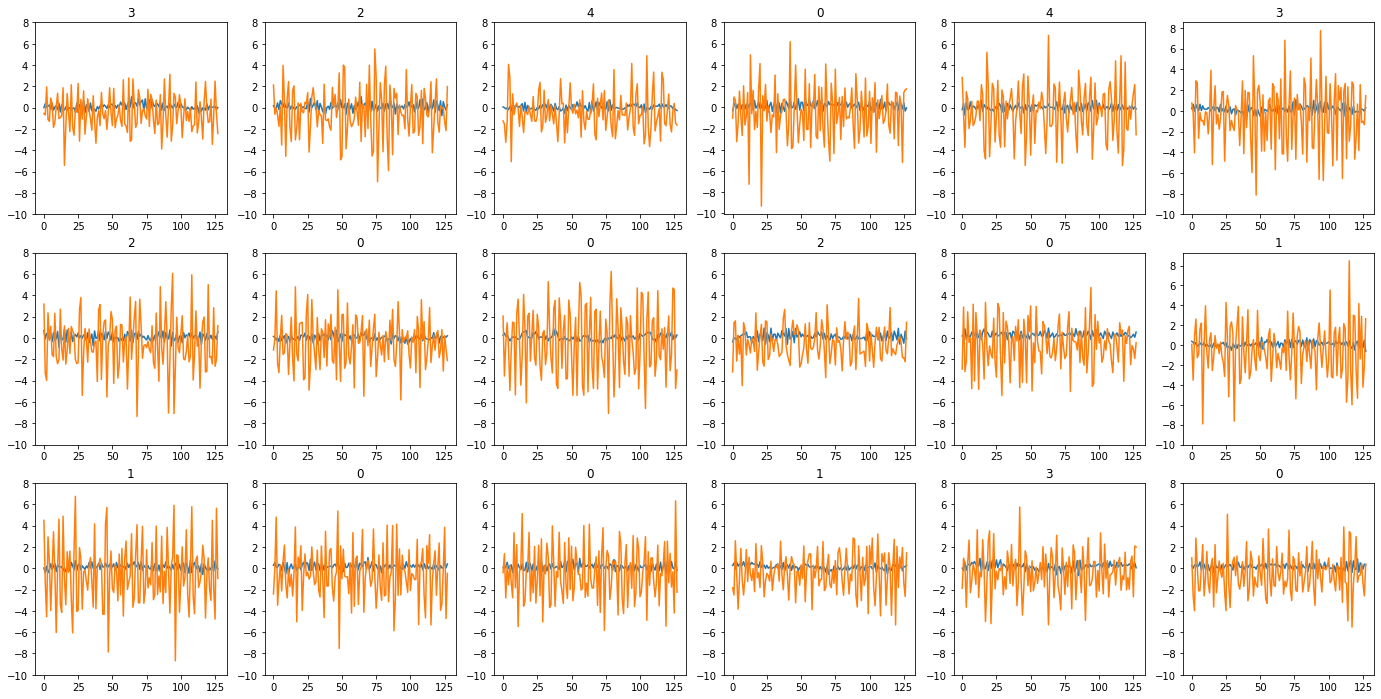

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

#Fast Fourier Transform and Continuous Wavelet Transform

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [ ]:
import  pywt
from scipy import fftpack

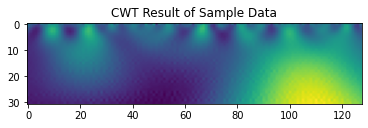

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

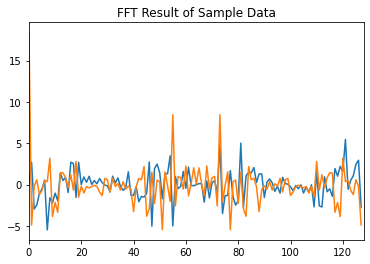

In [ ]:
# https://sdc-james.gitbook.io/onebook/4.-numpy-and-scipy/4.3-scipy/4.3.3.-fast-fourier-transforms-scipy.fftpack

imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

#CUSTOM MODELING 1 (BASIC) _ ACCURACY 0.9365

In [ ]:
CUSTOM_MODEL1 = keras.models.Sequential([
        #keras.layers.LSTM(16, input_shape=(128,2), activation='relu'),
        keras.layers.Flatten(input_shape=(128,2)),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dense(8, activation = 'relu'),
        keras.layers.Dense(5, activation = 'softmax'),
])

CUSTOM_MODEL1.summary()

CUSTOM_MODEL1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


history = CUSTOM_MODEL1.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 45        
Total params: 4,293
Trainable params: 4,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16007/16007 [==============================] - 45s 3ms/step - loss: 0.4664 - accuracy: 0.8191 - val_loss: 0.1710 - val_accuracy: 0.9416
Epoch 2/10
16007/16007 [==============================] - 45s 3ms/step - loss: 0.1281 - accuracy: 0.957

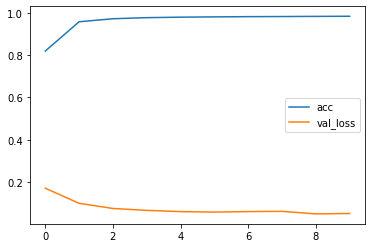

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f138a6b1e10>]],
      dtype=object)

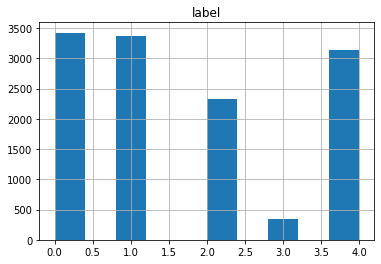

In [ ]:
pred=CUSTOM_MODEL1.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL1.csv', index = False)
sub.hist()

# CUSTOM MODELING 2 (STFT, CNN) _ ACCURACY 0.9898

In [ ]:
def tf_stft(series_t):
  spectro = tf.signal.stft(series_t, frame_length = 32, frame_step = 8)
  return spectro

def tf_reshape_stft(series, label):
  series_t = tf.transpose(series)
  spectros1 = tf.expand_dims(tf_stft(series_t[0]), axis=-1)
  spectros2 = tf.expand_dims(tf_stft(series_t[1]), axis=-1)
  spectros = tf.concat([spectros1, spectros2], axis = -1)
  spectros = tf.abs(spectros)
  return spectros, label

In [ ]:
Train_Dataset_stft = Train_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Valid_Dataset_stft = Valid_Dataset.unbatch().map(tf_reshape_stft).batch(128)
Test_Dataset_stft = Test_Dataset.unbatch().map(tf_reshape_stft).batch(128)

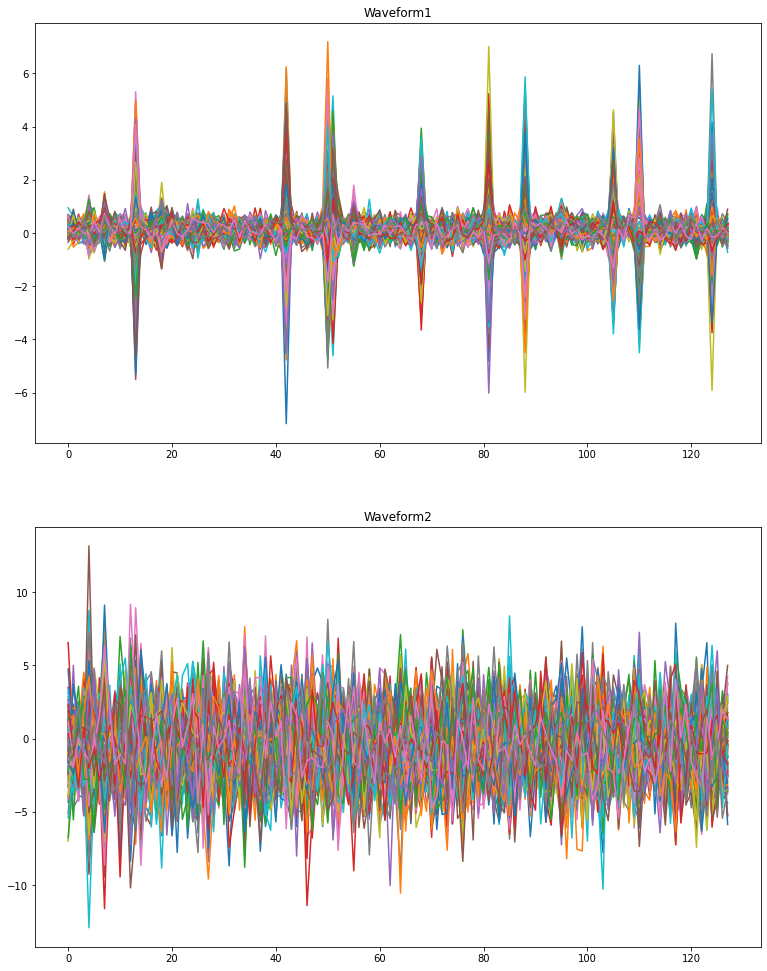

In [ ]:
for ser, lable in Train_Dataset.take(1):
  fig, axes = plt.subplots(2, figsize=(13, 17))
  timescale = np.arange(ser.shape[0])
  axes[0].plot(timescale, ser[:,:,0].numpy())
  axes[0].set_title('Waveform1')
  axes[1].plot(timescale, ser[:,:,1].numpy())
  axes[1].set_title('Waveform2')
  plt.show()

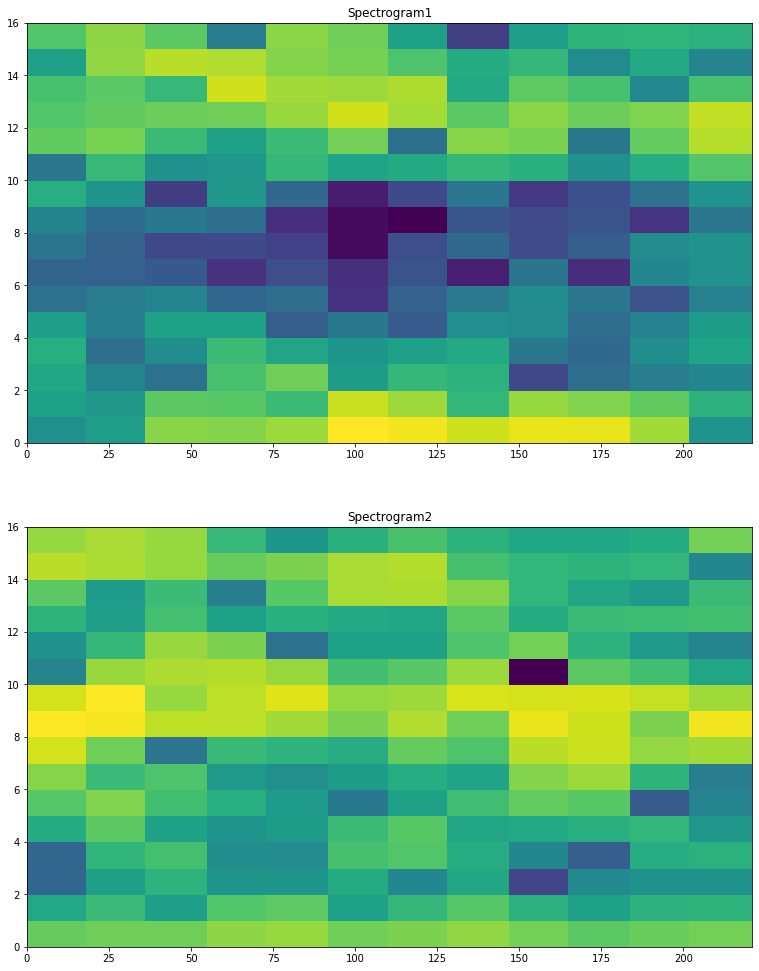

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

for spec, lable in d.take(1):
  fig, axes = plt.subplots(2, figsize=(13, 17))
  plot_spectrogram(spec[:,:,0].numpy(), axes[0])
  axes[0].set_title('Spectrogram1')
  plot_spectrogram(spec[:,:,1].numpy(), axes[1])
  axes[1].set_title('Spectrogram2')
  plt.show()

In [ ]:
Train_Dataset_stft

<BatchDataset shapes: ((None, 13, 17, 2), (None,)), types: (tf.float64, tf.float64)>

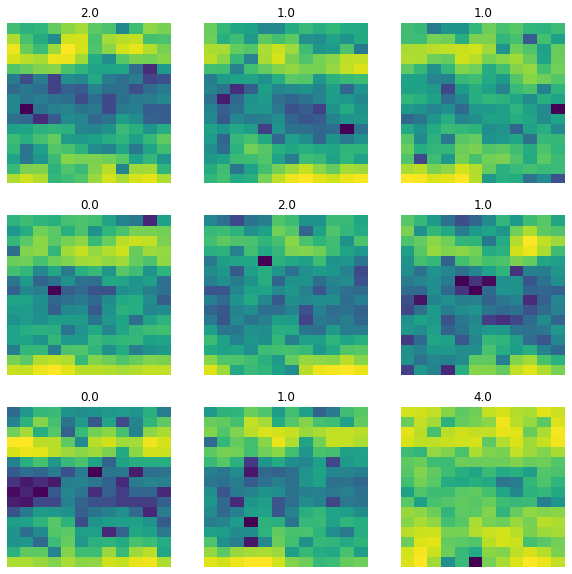

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(Train_Dataset_stft.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram[:,:,0].numpy()), ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()

In [ ]:
CUSTOM_MODEL2 = keras.models.Sequential([
        keras.layers.Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2)),
        keras.layers.MaxPool2D(pool_size = (2,2)),        
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(16, activation = 'relu'),
        keras.layers.Dense(5, activation = 'softmax'),
])

CUSTOM_MODEL2.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)

CUSTOM_MODEL2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


history = CUSTOM_MODEL2.fit(Train_Dataset_stft, epochs = 3, shuffle = True, validation_data = Valid_Dataset_stft)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 13, 17, 12)        228       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 8, 12)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 8, 16)          1744      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 4, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_19 (Dense)             (None, 16)               

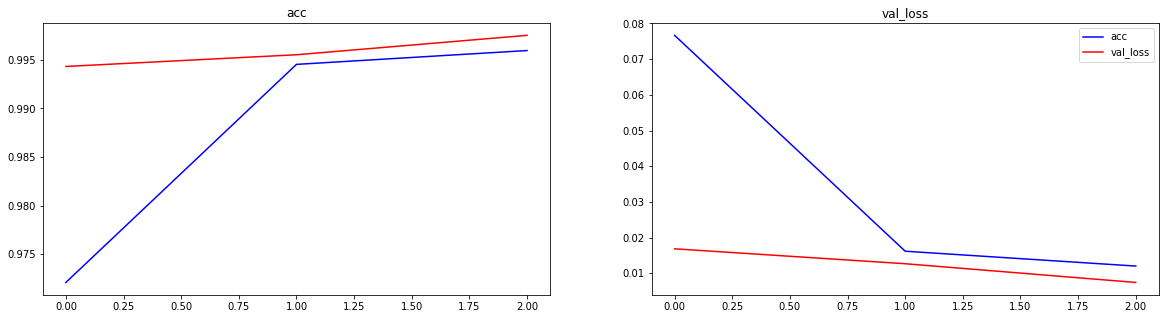

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'], c = 'b')
ax1.plot(history.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'], c = 'b')
ax2.plot(history.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e1193410>]],
      dtype=object)

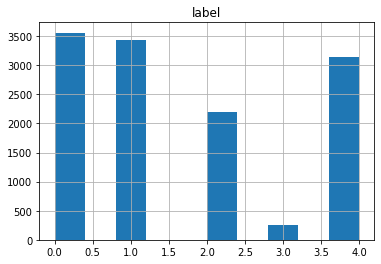

In [ ]:
pred=CUSTOM_MODEL2.predict(Test_Dataset_stft)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL2.csv', index = False)
sub.hist()

# CUSTOM MODELING 3 (STFT, STATISTIC, CNN) _ ERROR

In [ ]:
def tf_statistic(series, label):
  max = tf.expand_dims(tf.math.reduce_max(series, axis = 0), axis = 0)
  min = tf.expand_dims(tf.math.reduce_min(series, axis = 0), axis = 0)
  mean = tf.expand_dims(tf.math.reduce_mean(series, axis = 0), axis = 0)
  std = tf.expand_dims(tf.math.reduce_std(series, axis = 0), axis = 0)

  stat = tf.concat([max, min, mean, std], axis = 0)

  return stat, label

In [ ]:
Train_Dataset_stat = Train_Dataset.unbatch().map(tf_statistic).batch(128)
Valid_Dataset_stat = Valid_Dataset.unbatch().map(tf_statistic).batch(128)
Test_Dataset_stat = Test_Dataset.unbatch().map(tf_statistic).batch(128)

In [ ]:
Train_Dataset_stat

<BatchDataset shapes: ((None, 4, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
def build_model():
    input1 = keras.layers.Input(shape=(13, 17, 2), dtype=tf.float64, name='x1')
    input2 = keras.layers.Input(shape=(4, 2), dtype=tf.float64, name='x2')
    input2_ = keras.layers.Flatten()(input2)

    y1 = keras.layers.Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2))(input1)
    y1 = keras.layers.MaxPool2D(pool_size = (2,2))(y1)
    y1 = keras.layers.Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (13, 17, 2))(y1)
    y1 = keras.layers.MaxPool2D(pool_size = (2,2))(y1)
    y1 = keras.layers.Flatten()(y1)

    y2 = keras.layers.Concatenate(axis=1)([y1, input2_])
    y2 = keras.layers.Dense(128, activation = 'relu')(y2)
    y2 = keras.layers.Dropout(0.2)(y2)
    y2 = keras.layers.Dense(64, activation = 'relu')(y2)
    y2 = keras.layers.Dense(16, activation = 'relu')(y2)
    y = keras.layers.Dense(5, activation = 'softmax')(y2)
    return keras.models.Model(inputs=[input1, input2], outputs=y)

In [ ]:
CUSTOM_MODEL3 = build_model()
CUSTOM_MODEL3.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)

CUSTOM_MODEL3.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 [(None, 13, 17, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 17, 12)   228         x1[0][0]                         
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 6, 8, 12)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 8, 16)     1744        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
Train_Dataset_fusion_x = tf.data.Dataset.zip((Train_Dataset_stft.unbatch(), Train_Dataset_stat.unbatch())).map(lambda x1, x2: {'x1': x1[0], 'x2': x2[0]})
Train_Dataset_fusion_y = Train_Dataset_stft.unbatch().map(lambda x, y: y)

Train_Dataset_fusion = tf.data.Dataset.zip((Train_Dataset_fusion_x, Train_Dataset_fusion_y)).batch(128)

Valid_Dataset_fusion_x = tf.data.Dataset.zip((Valid_Dataset_stft.unbatch(), Valid_Dataset_stat.unbatch())).map(lambda x1, x2: {'x1': x1[0], 'x2': x2[0]})
Valid_Dataset_fusion_y = Valid_Dataset_stft.unbatch().map(lambda x, y: y)

Valid_Dataset_fusion = tf.data.Dataset.zip((Valid_Dataset_fusion_x, Valid_Dataset_fusion_y)).batch(128)

In [ ]:
Train_Dataset_fusion

<BatchDataset shapes: ({x1: (None, 13, 17, 2), x2: (None, 4, 2)}, (None,)), types: ({x1: tf.float64, x2: tf.float64}, tf.float64)>

In [ ]:
history = CUSTOM_MODEL3.fit(Train_Dataset_fusion, epochs = 15, shuffle = True, validation_data = Valid_Dataset_fusion)

Epoch 1/15
  16003/Unknown - 259s 14ms/step - loss: 1.6072 - accuracy: 0.2181

**error** 

fit 함수 돌리면 RAM을 다 쓰고 초기화 됨. Dataset_fusion을 만드는 과정에서 오류가 발생하는 것으로 예상

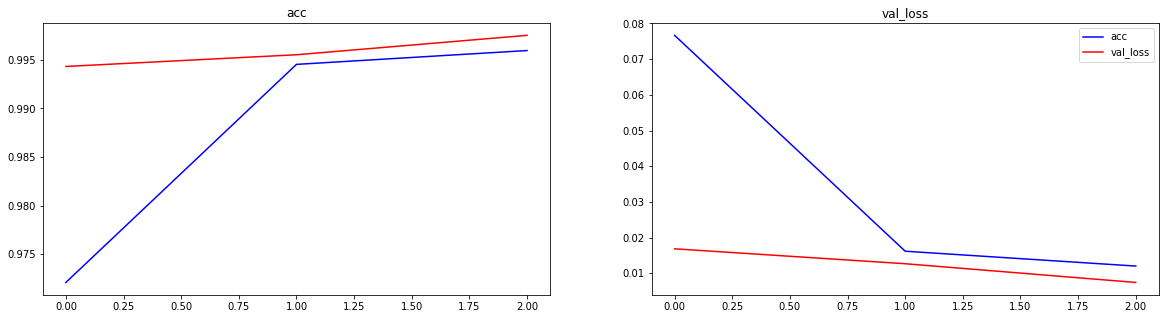

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['accuracy'], c = 'b')
ax1.plot(history.history['val_accuracy'], c = 'r')
ax1.set_title('acc')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['loss'], c = 'b')
ax2.plot(history.history['val_loss'], c = 'r')
ax2.set_title('val_loss')
plt.legend(['acc', 'val_loss'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e1193410>]],
      dtype=object)

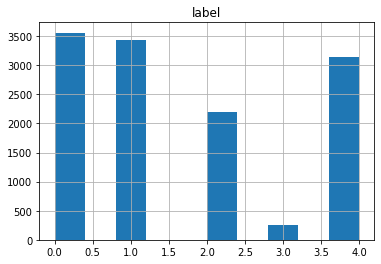

In [ ]:
pred=CUSTOM_MODEL2.predict(Test_Dataset_stft)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/TNT/산업인공지능/실습/1, 2주차 phmap/예측/CUSTOM_MODEL2.csv', index = False)
sub.hist()